In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1139, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 1139 (delta 41), reused 41 (delta 36), pack-reused 1077 (from 1)
Receiving objects: 100% (1139/1139), 29.38 MiB | 20.51 MiB/s, done.
Resolving deltas: 100% (698/698), done.
Filtering content: 100% (33/33), 1.75 GiB | 25.68 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install pykalman
!pip install ta
!pip install scikit-optimize

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0

In [3]:
# bunch of the initialization code #

### RESULTS IMPORTS ###
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any, Sequence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoConfig
from torch.utils.data import DataLoader, TensorDataset

# Custom Imports
from models.statistical_models import kalman_filter_average, kalman_filter_regression
from models.transformer_model import TimeSeriesTransformerv1, get_cosine_schedule_with_warmup_and_min_lr
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###


### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt import plots as skplots
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple
import time
import random
from sklearn.metrics import mean_squared_error


from utils.helpers import return_score
from utils.visualization import results_to_latex
from utils.optimization import bayesian_optimize_workflow
### HYPERPARAM OPTIMIZATION IMPORTS ###

wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 1. Optimization

## Kalman Filter

In [7]:
search_space_kalman = [ # 'name' is used directly as a kwarg
    Real(1e-5, 0.1, name='delta', prior='log-uniform'),
    Real(0.5, 4, name='obs_cov_reg', prior='log-uniform'),
    Real(0.001, 0.1, name='trans_cov_avg', prior='log-uniform'),
    Real(0.1, 10, name='obs_cov_avg', prior='log-uniform')
]
SEED = 3178749

# call func
res_kalman = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=3,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_kalman,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_kalman]
best_params = {k: res_kalman.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_kalman.fun
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")

Iteration No: 1 started. Evaluating function at random point.
total_mse_list: [2.1022343099429945, 7.375663257415374, 17.39179780732058, 36.728427136572826, 8.585322200626345, 190.3909003344893, 68.60078269577357, 51.10028001909107, 71.2798495588501, 32.159400375716515, 21.10569583779952, 5.3058167760398325]
mean mse: 42.677180859136506
Current hyperparameters: {'delta': 0.004192503695046673, 'obs_cov_reg': 0.7709033173518481, 'trans_cov_avg': 0.08962654230255038, 'obs_cov_avg': 4.320486978195314}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 36.3176
Function value obtained: 42.6772
Current minimum: 42.6772
Iteration No: 2 started. Evaluating function at random point.
total_mse_list: [2.0480935448647064, 7.27876282445266, 18.233467167925355, 36.725321194673555, 10.400671424122756, 190.520927594238, 68.45000028872431, 50.858681704743006, 71.08305243503999, 32.15840574652447, 21.092548645696045, 5.211785553683892]
mean mse: 42.83847651039073
Current hyperparameters:

best_params: {'delta': 0.1, 'obs_cov_reg': 1.580094597096321, 'trans_cov_avg': 0.1, 'obs_cov_avg': 6.246725340878335}
best_mean_mse: 42.49138342881579


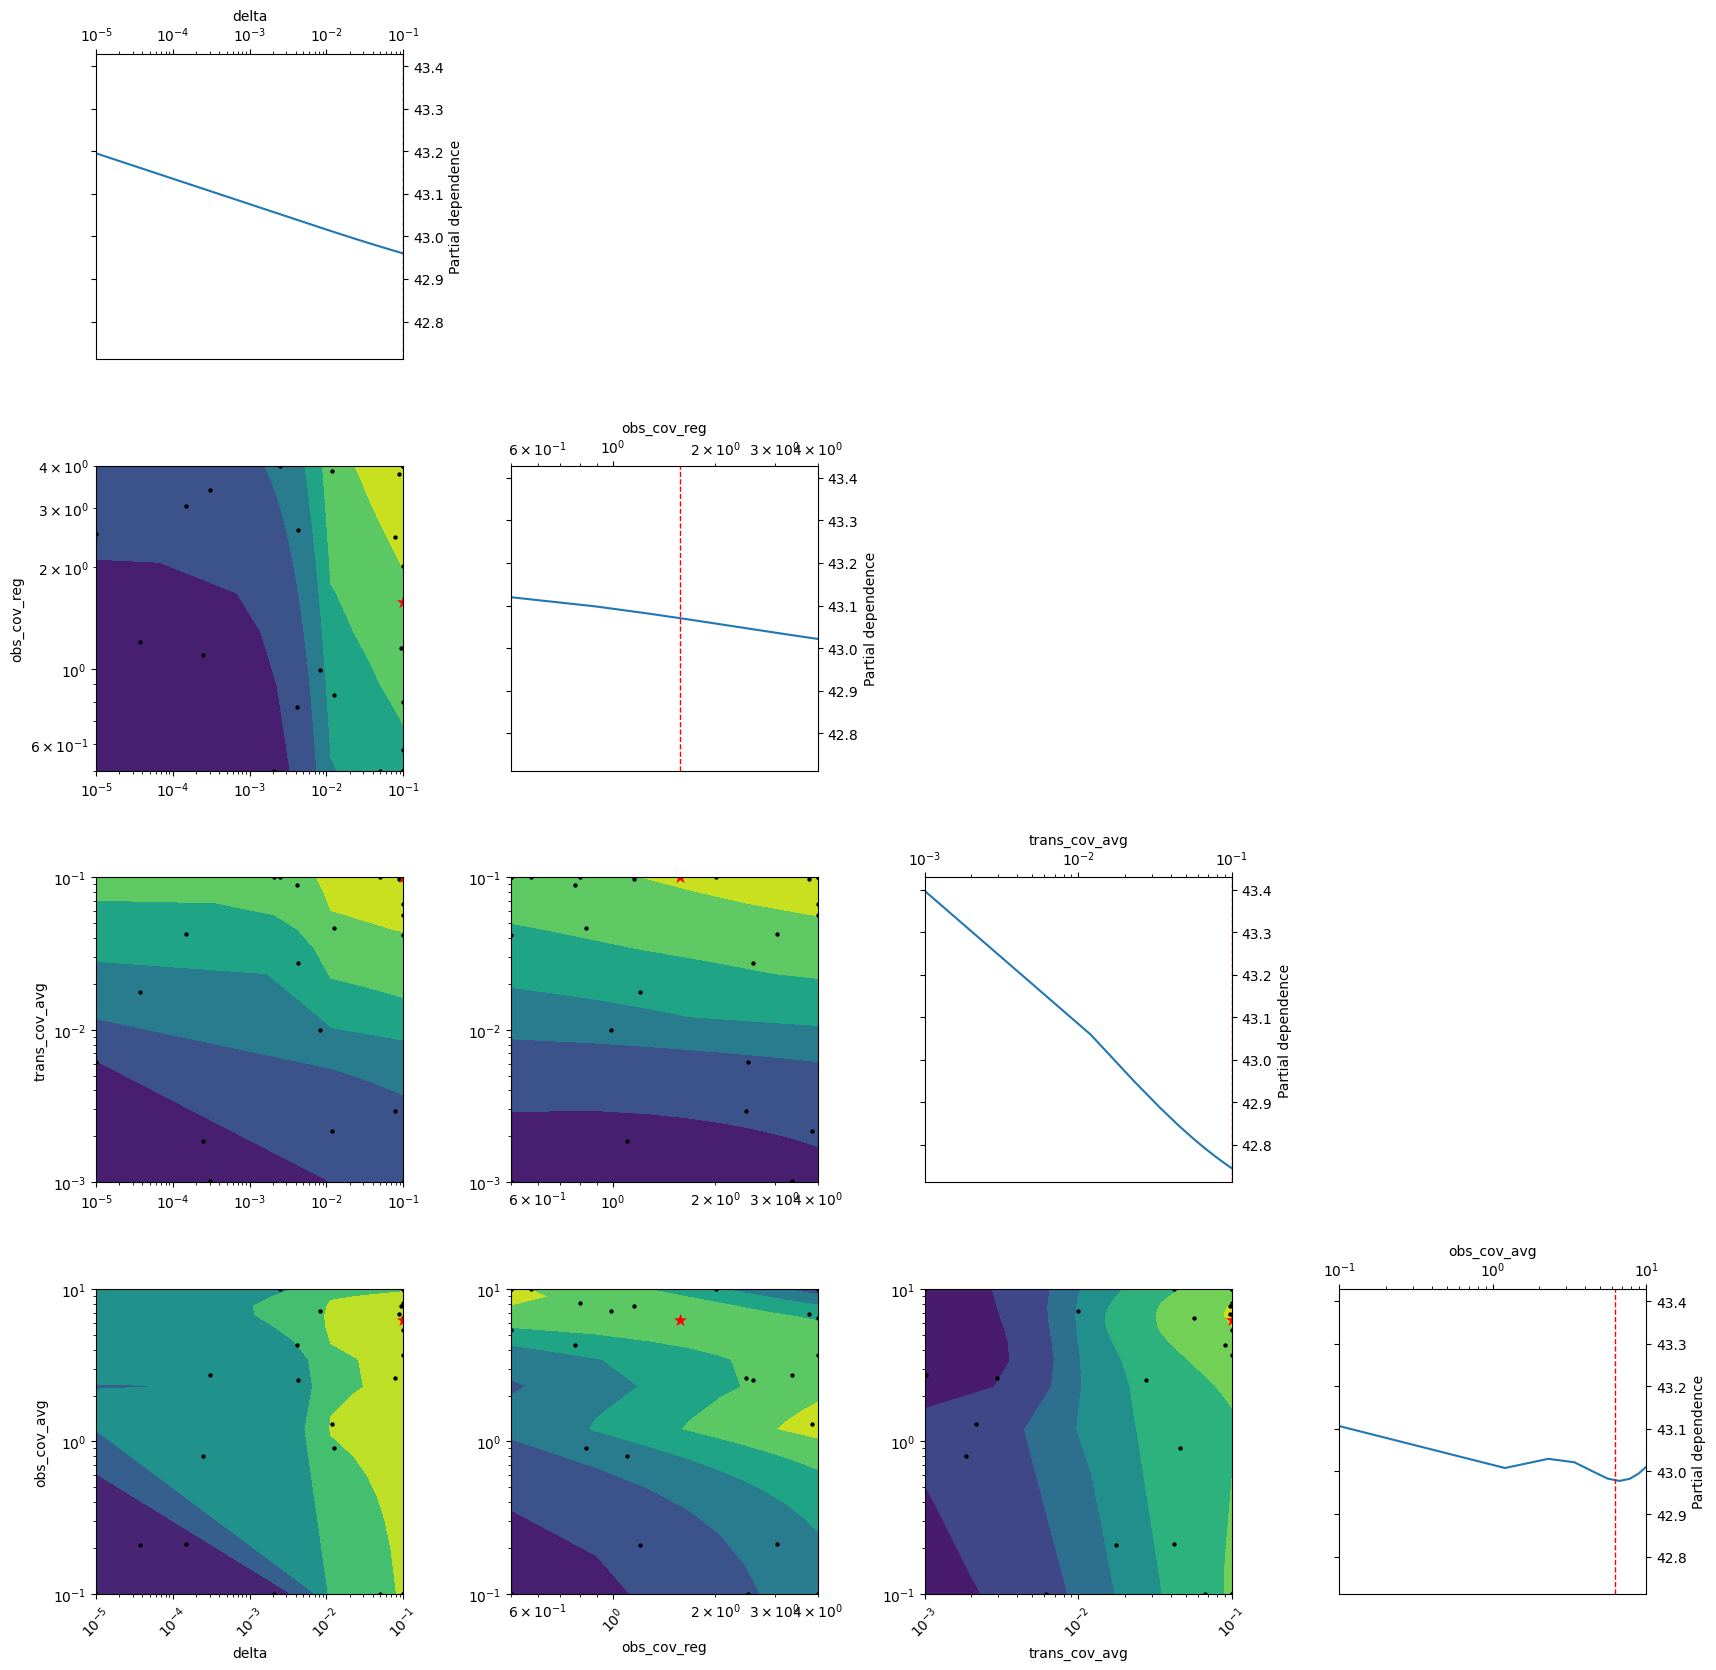

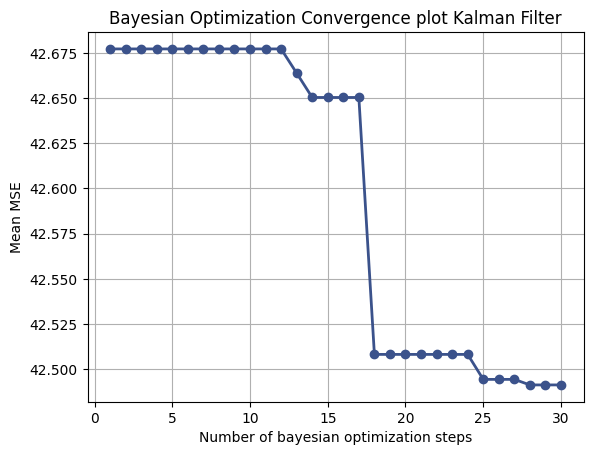

In [27]:
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_kalman, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_kalman)
ax.set_title("Bayesian Optimization Convergence plot Kalman Filter")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

## Transformer

In [ ]:
search_space_transformer = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: architecture ##
  d_model: int = 256,
  nhead: int = 8,
  num_layers: int = 4,
  dropout: float = 0.1,
  ## optimized hyperparams: architecture ##
  ## optimized hyperparams: learning algorithm ##
  learning_rate: float = 1e-4,
  min_learning_rate: float = 5e-5,
  warmup_ratio: float = 0.0,
  weight_decay: float = 0.1,
  batch_size: int = 64,
  adam_beta1: float = 0.9,
  adam_beta2: float = 0.95,
  adam_epsilon: float = 1e-8,
  ## optimized hyperparams: learning algorithm ##
]
SEED = 3178749

# call func
res_transformer = bayesian_optimize_workflow(
    execute_workflow_fn=execute_transformer_workflow,
    top_pair_count=10,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2021,
    search_space=search_space_transformer,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names_transformer = [dim.name for dim in search_space_transformer]
best_params_transformer = {k: res_transformer.x[i] for i, k in enumerate(param_names)}
best_mean_mse_transformer = res_transformer.fun
print(f"best_params: {best_params_transformer}")
print(f"best_mean_mse: {best_mean_mse_transformer}")

In [20]:
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_transformer, levels=5, n_points=10, size=5)

NameError: name 'res_transformer' is not defined

## Time-MoE

In [ ]:
search_space_timemoe = [ # 'name' is used directly as a kwarg
    ...
]
SEED = 3178749

# call func
res_timemoe = bayesian_optimize_workflow(
    execute_workflow_fn=execute_timemoe_workflow,
    top_pair_count=10,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2021,
    search_space=search_space_timemoe,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_timemoe]
best_params = {k: res_timemoe.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_timemoe.fun

# 2. Results

In [7]:
### Unchanged variables ###
verbose = True
return_datasets = True
### Unchanged variables ###

## Kalman Filter

In [68]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
    delta=1e-3,
    obs_cov_reg= 2.,
    trans_cov_avg= 0.01,
    obs_cov_avg= 1.
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

def execute_kalman_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 1,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  ## optimized hyperparams ##
  return_datasets: bool = False,
  verbose: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl", # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pairs_timeseries.columns):
      raise KeyError(f"pairs_timeseries must contain {required}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train_univariate = pairs_timeseries.iloc[:train_size][target_col]
  dev_univariate = pairs_timeseries.iloc[train_size:train_size + dev_size][target_col]
  test_univariate = pairs_timeseries.iloc[train_size + dev_size:][target_col]

  train_multivariate = pairs_timeseries.iloc[:train_size]
  dev_multivariate = pairs_timeseries.iloc[train_size:train_size + dev_size]
  test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")

  beta_t_train = kalman_filter_regression(
      kalman_filter_average(train_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(train_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_train_raw = train_multivariate[col_s1] + train_multivariate[col_s2] * beta_t_train # merely used for scaling dev without lookahead bias

  # get dev forecasts
  beta_t_dev = kalman_filter_regression(
      kalman_filter_average(dev_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(dev_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_dev_raw = dev_multivariate[col_s1] + dev_multivariate[col_s2] * beta_t_dev
  forecast_dev = (forecast_dev_raw - forecast_train_raw.mean()) / forecast_train_raw.std()

  # get test forecasts
  beta_t_test = kalman_filter_regression(
      kalman_filter_average(test_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(test_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_test_raw = test_multivariate[col_s1] + test_multivariate[col_s2] * beta_t_test
  forecast_test = (forecast_test_raw - forecast_dev_raw.mean()) / forecast_dev_raw.std()

  if look_back == 1:
      # Calculate mse values
      test_mse = mean_squared_error(test_univariate, forecast_test)
      test_var = np.var(test_univariate)
      test_nmse = test_mse / test_var if test_var != 0 else 0.0

      # also for validation
      val_mse = mean_squared_error(dev_univariate, forecast_dev)
      val_var = np.var(dev_univariate)
      val_nmse = val_mse / val_var if val_var != 0 else 0.
  else:
      raise NotImplementedError("Warning: look_back > 1 not yet implemented. Returning None for mse.")

  ### TRADING ###
  # calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

  test_s1 = test_multivariate['S1_close']
  test_s2 = test_multivariate['S2_close']

  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1, test_s2, forecast_test, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  # calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=0, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  current_result_dir = filename_base.replace(".pkl", "_kalman")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  if return_datasets:
      output.update(
          dict(
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1,
            test_s2_shortened=test_s2,
            forecast_test_shortened_series=forecast_test,
            gt_test_shortened_series=test_univariate
          )
      )
  return output

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
results_kalman_2022 = []
all_outputs_kalman_2022 = []
num_results = min(len(pairs_data_filtered), 8)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_kalman_2022.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_kalman_2022.append(output_model)

Gathering [...]:   0%|          | 0/8 [00:00<?, ?it/s]

Split sizes — train: 3274, dev: 250, test: 252

Validation MSE: 2.132678736809354
Test MSE: 116.0627760861861
YOY Returns: 5.47%
YOY Std: +- 0.76%
GT Yoy: 0.67%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252

Validation MSE: 4.719941604268845
Test MSE: 12.622879355838935
YOY Returns: 1.32%
YOY Std: +- 0.34%
GT Yoy: 0.42%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252

Validation MSE: 21.509471763433723
Test MSE: 124.59000022744758
YOY Returns: 6.62%
YOY Std: +- 0.20%
GT Yoy: 0.83%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3274, dev: 250, test: 252

Validation MSE: 1.9352262475033077
Test MSE: 6.694927749240118
YOY Returns: 2.11%
YOY Std: +- 0.45%
GT Yoy: 1.23%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252

Validation MSE: 34.981416905205634
Te

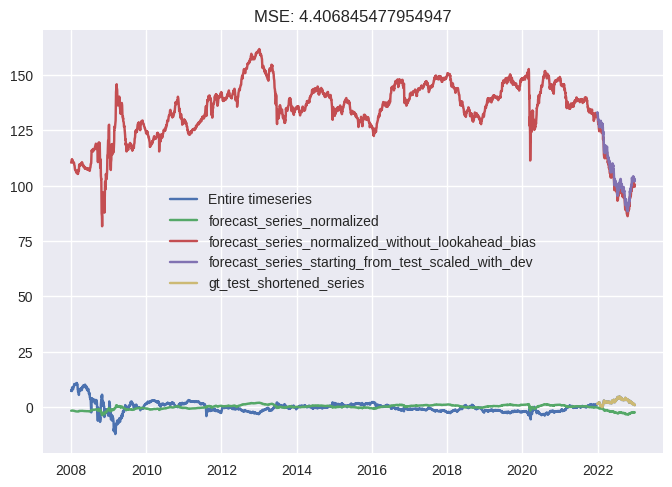

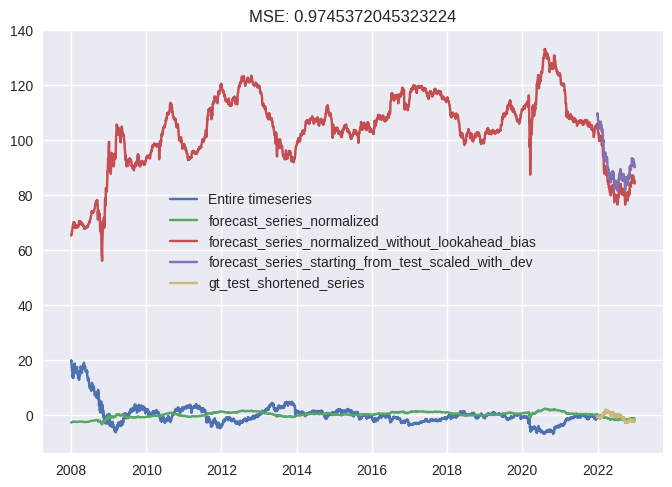

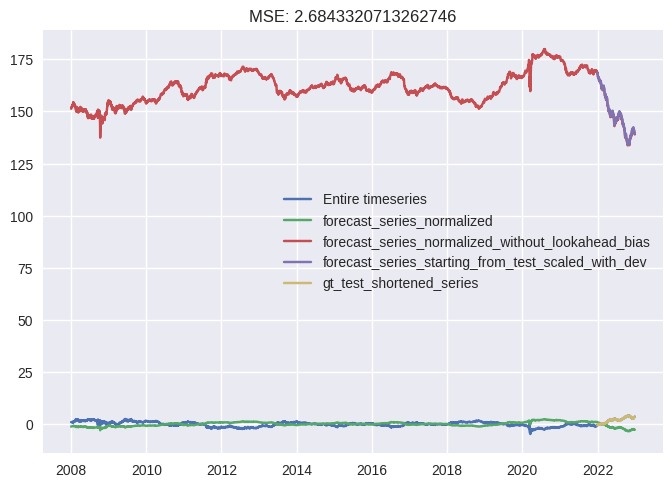

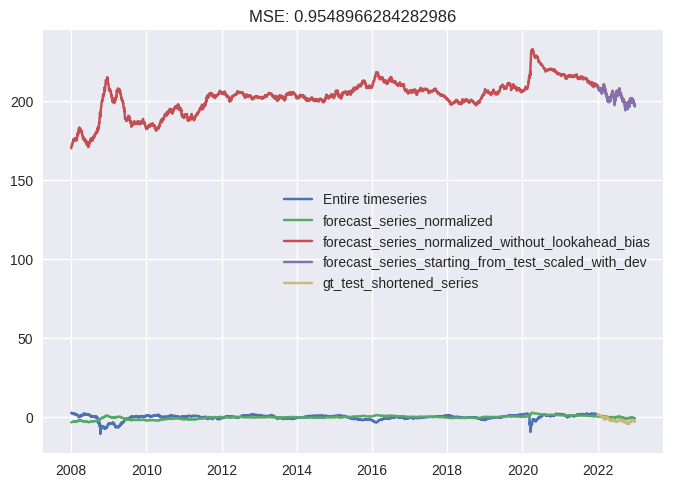

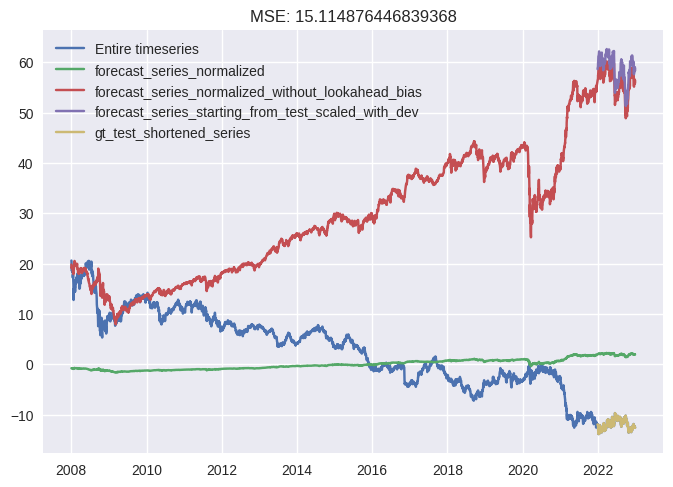

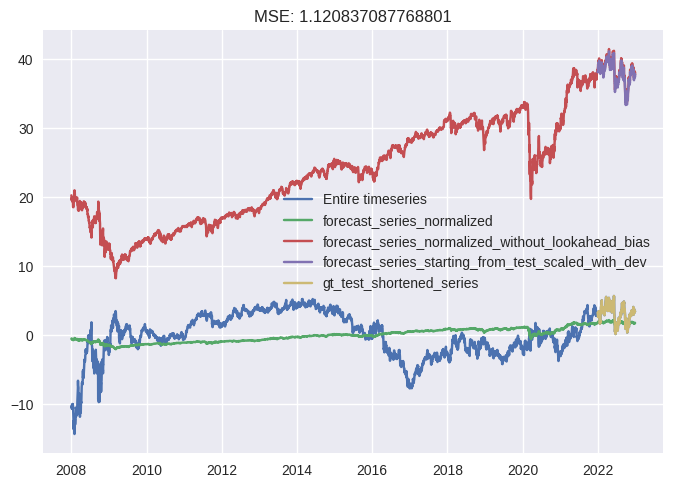

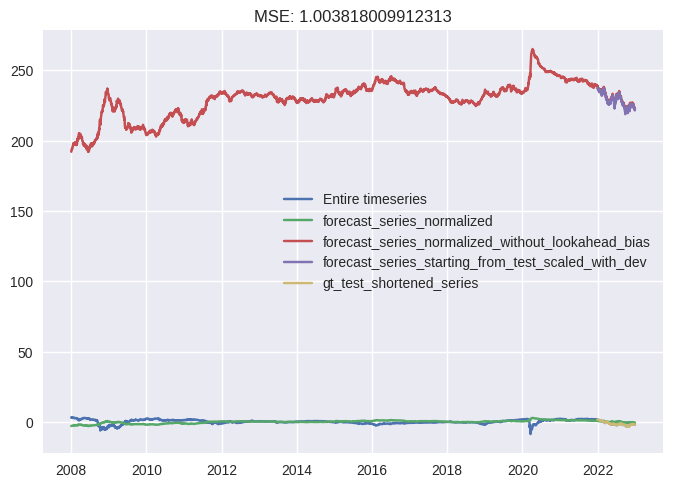

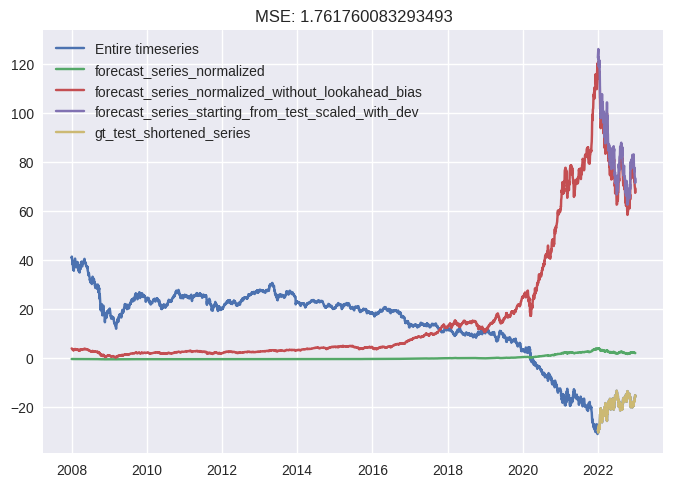

In [28]:
  # test_s1_shortened=test_s1,
  # test_s2_shortened=test_s2,
  # forecast_test_shortened_series=forecast_test_series,
  # gt_test_shortened_series=gt_test_series
for i, output in enumerate(all_outputs_kalman_2022):
    # gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    # plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True)
    # plt.show()
    plt.title(f"MSE: {output['test_mse']}")
    plt.plot(output['pairs_timeseries']['Spread_Close'], label="Entire timeseries")
    # plt.plot(output['forecast_series'], label="forecast_series")
    plt.plot(output['forecast_series_normalized'], label="forecast_series_normalized")
    plt.plot(output['forecast_series_normalized_without_lookahead_bias'], label="forecast_series_normalized_without_lookahead_bias")
    plt.plot(output['forecast_series_starting_from_test_scaled_with_dev'], label="forecast_series_starting_from_test_scaled_with_dev")
    plt.plot(output['gt_test_shortened_series'], label="gt_test_shortened_series")
    plt.legend()
    plt.show()

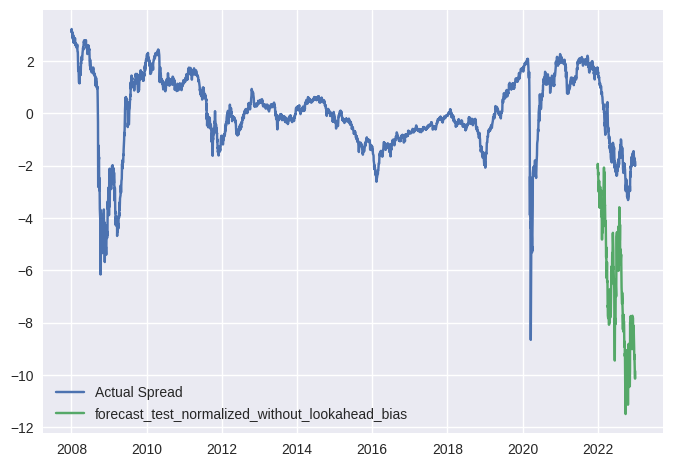

In [67]:
output = all_outputs_kalman_2022[-2]

pairs_timeseries = output['pairs_timeseries']
col_s1 = "S1_close"
col_s2 = "S2_close"
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
total_len = len(pairs_timeseries)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
train_multivariate = pairs_timeseries.iloc[:train_size]
test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]
dev_multivariate = pairs_timeseries.iloc[train_size:train_size + dev_size]
pairs_timeseries_univariate = pairs_timeseries["Spread_Close"]

beta_t = kalman_filter_regression(
    kalman_filter_average(pairs_timeseries[col_s1],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    kalman_filter_average(pairs_timeseries[col_s2],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    delta=delta,
    obs_cov=obs_cov_reg
)[:, 0]
forecast_series = pairs_timeseries[col_s1] + pairs_timeseries[col_s2] * beta_t
forecast_series_normalized = default_normalize(forecast_series)
forecast_series_normalized_manually = (forecast_series - forecast_series.mean()) / forecast_series.std()

###
beta_t_dev = kalman_filter_regression(
    kalman_filter_average(dev_multivariate[col_s1],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    kalman_filter_average(dev_multivariate[col_s2],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    delta=delta,
    obs_cov=obs_cov_reg
)[:, 0]
forecast_dev_raw = dev_multivariate[col_s1] + dev_multivariate[col_s2] * beta_t_dev
forecast_dev = default_normalize(forecast_dev_raw)

beta_t_starting_from_test = kalman_filter_regression(
    kalman_filter_average(test_multivariate[col_s1],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    kalman_filter_average(test_multivariate[col_s2],
                          transition_cov=trans_cov_avg,
                          obs_cov=obs_cov_avg),
    delta=delta,
    obs_cov=obs_cov_reg
)[:, 0]
forecast_test_raw = test_multivariate[col_s1] + test_multivariate[col_s2] * beta_t_starting_from_test
forecast_test_normalized_without_lookahead_bias = (forecast_test_raw - forecast_dev_raw.mean()) / forecast_dev_raw.std()
###

plt.plot(pairs_timeseries['Spread_Close'], label="Actual Spread")
plt.plot(forecast_test_normalized_without_lookahead_bias, label="forecast_test_normalized_without_lookahead_bias")
plt.legend()

In [ ]:
print(results_to_latex(results_kalman_2022))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $5.58\times 10^{-4}$ & 5.14612 & 218.30852 & $6.73\% \pm 1.39\%$ & 0.61\% & 1.06 \\
2. (IFGL,EMB) & $1.40\times 10^{-3}$ & 2.00331 & 294.60973 & $8.65\% \pm 1.97\%$ & 0.43\% & 1.08 \\
3. (IGSB,BND) & $1.89\times 10^{-3}$ & 68.42516 & 32.85656 & $1.97\% \pm 0.41\%$ & 0.88\% & 1.01 \\
\bottomrule
\end{tabular}
}
\caption{Model performance and return statistics for all tested pairs.}
\end{table}


## Transformer

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
  ## optimized hyperparams: architecture ##
  d_model= 256,
  nhead= 8,
  num_layers= 4,
  dropout = 0.1,
  ## optimized hyperparams: architecture ##
  ## optimized hyperparams: learning algorithm ##
  learning_rate = 1e-4,
  min_learning_rate = 5e-5,
  warmup_ratio = 0.0,
  weight_decay = 0.1,
  batch_size= 64,
  adam_beta1 = 0.9,
  adam_beta2 = 0.95,
  adam_epsilon = 1e-8
  ## optimized hyperparams: learning algorithm ##
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
results_transformer_2022 = []
all_outputs_transformer_2022 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, epochs=10, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_transformer_2022.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_transformer_2022.append(output_model)

Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Using device: cuda
Split sizes — train: 3274, dev: 250, test: 252
Epoch 010 | train MSE 0.026590 | val MSE 0.007395

Validation MSE: 0.11768183165195598
Test MSE: 0.07826846136668489
YOY Returns: 0.77%
YOY Std: +- 0.04%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Using device: cuda
Split sizes — train: 3274, dev: 250, test: 252
Epoch 010 | train MSE 0.020455 | val MSE 0.004559

Validation MSE: 0.10854966875197346
Test MSE: 0.06757213082911231
YOY Returns: 0.36%
YOY Std: +- 0.01%
GT Yoy: 0.43%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Using device: cuda
Split sizes — train: 3274, dev: 250, test: 252
Epoch 010 | train MSE 0.027080 | val MSE 0.013550

Validation MSE: 0.11568501815932074
Test MSE: 0.29119278540273247
YOY Returns: 0.78%
YOY Std: +- 0.03%
GT Yoy: 0.88%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Using device: cuda
Split sizes — train: 3274, dev: 250, test: 252
Epoch 010 | train MSE 0.024030 |

In [ ]:
for i, output in enumerate(all_outputs_transformer_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_transformer_2022_{i}")

Saved plot to all_outputs_transformer_2022_0_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_1_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_2_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_3_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_4_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_5_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_6_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_7_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_8_groundtruth_comparison.png
Saved plot to all_outputs_transformer_2022_9_groundtruth_comparison.png


## Time-MoE

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
  ## optimized hyperparams: learning algorithm ##
  learning_rate=1e-4,
  min_learning_rate=5e-5,
  warmup_ratio=0.0,
  weight_decay=0.1,
  global_batch_size=64, # (just the batch size) other option would be micro_batch_size, which sets batch size per device
  adam_beta1=0.9,
  adam_beta2=0.95,
  adam_epsilon=1e-8,
  ## optimized hyperparams: learning algorithm ##
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###
### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
results_timemoe_2022 = []
all_outputs_timemoe_2022 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe_2022.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_timemoe_2022.append(output_model)


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:45:28,090 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3554.49it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.07027827132072963
Test MSE: 0.1614310011637293
YOY Returns: 0.71%
YOY Std: +- 0.16%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:45:39,149 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2134.51it/s]


Step,Training Loss
1,0.020900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.1305880266819479
Test MSE: 0.053724216801809985
YOY Returns: 0.39%
YOY Std: +- 0.15%
GT Yoy: 0.43%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:45:50,341 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3823.43it/s]


Step,Training Loss
1,0.025900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09116217081731957
Test MSE: 0.026181393174229645
YOY Returns: 0.85%
YOY Std: +- 0.12%
GT Yoy: 0.88%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:01,257 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1861.65it/s]


Step,Training Loss
1,0.033300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08512061650040616
Test MSE: 0.028928096590402966
YOY Returns: 0.94%
YOY Std: +- 0.30%
GT Yoy: 1.30%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:12,415 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2449.94it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.0955269260518189
Test MSE: 0.21309144824649326
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:24,047 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3075.00it/s]


Step,Training Loss
1,0.022400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03617782124035344
Test MSE: 0.11958219245546113
YOY Returns: 0.14%
YOY Std: +- 0.11%
GT Yoy: 0.27%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:34,878 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


Step,Training Loss
1,0.026800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.13920061462204822
Test MSE: 0.02691696927354444
YOY Returns: 0.75%
YOY Std: +- 0.27%
GT Yoy: 1.15%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:45,851 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3942.02it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.4407105413352309
Test MSE: 0.8651953686525966
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:46:57,191 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.514559532678167
Test MSE: 1.144887339550402
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-15 12:47:08,343 - log_util.py[pid:1779;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1625.70it/s]


Step,Training Loss
1,0.013200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.42999862771412656
Test MSE: 0.5599547784591201
YOY Returns: -62.04%
YOY Std: +- 52.02%
GT Yoy: 3.70%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PHO)
  


In [ ]:
for i, output in enumerate(all_outputs_timemoe_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_timemoe_2022_{i}")

Saved plot to all_outputs_timemoe_2022_0_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_1_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_2_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_3_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_4_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_5_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_6_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_7_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_8_groundtruth_comparison.png
Saved plot to all_outputs_timemoe_2022_9_groundtruth_comparison.png
